[CatBoost: Category Boosting]
- 고성능의 gradient boosting 라이브러리 <br>
- 특히, 범주형 데이터를 다루는 데 특화, 범주형 변수를 자동으로 처리할 수 있음 <br>
- 이를 통해 데이터 전처리 과정에서 원-핫 인코딩이나 레이블 인코딩과 같은 별도의 변환 작업이 필요 없음 <br>
- 그래디언트 부스팅 알고리즘은 일련의 예측 모델 (주로 의사 결정 트리)을 순차적으로 구축하여 전체 모델의 성능을 향상시키는 기법 <br>
- 과적합에 덜 민감하며, 다양한 데이터셋에서 안정적인 성능을 보임

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

< 데이터 불러오기 >

In [20]:
train_df = pd.read_csv('train.csv')

< 훈련 세트와 검증 세트로 데이터 분할 >

In [22]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X = data.drop(columns=['id', 'defects'])
y = data['defects']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape

# 결과해석: 훈련 세트에는 81,410개 샘플, 검증 세트에는 20,353개 샘플)



((81410, 21), (20353, 21))

< CatBoost 모델 훈련 >

In [ ]:
%pip install catboost

In [27]:
# verbose 옵션을 500으로 설정하여 500 반복마다 학습 진행 상황 출력

from catboost import CatBoostClassifier

# CatBoost classifier 초기화
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, eval_metric='AUC', random_seed=42, verbose=500)

# 모델 훈련
model.fit(X_train, y_train, eval_set=(X_val, y_val))

#결과해석: 모델은 159번 반복에서 최적의 성능(0.7883202)을 가지고 있으므로, 160번째 반복까지로 모델 축소 필요(불필요한 계산 반복 방지)

0:	test: 0.7668504	best: 0.7668504 (0)	total: 21.5ms	remaining: 21.5s
500:	test: 0.7872240	best: 0.7883202 (159)	total: 11s	remaining: 10.9s
999:	test: 0.7848624	best: 0.7883202 (159)	total: 21.9s	remaining: 0us

bestTest = 0.788320215
bestIteration = 159

Shrink model to first 160 iterations.


In [30]:
from sklearn.model_selection import GridSearchCV

GridSearchCV

sklearn.model_selection._search.GridSearchCV

< 성능 개선 시도(1) >
- parameter fine turing

In [35]:
# 개선된 설정으로 CatBoostClassifier 초기화
model_improved = CatBoostClassifier(
    iterations=1000,         # 트리의 수 (또는 학습의 반복 횟수)
    learning_rate=0.1,       # 학습률
    depth=6,                 # 트리의 깊이
    eval_metric='AUC',       # AUC로 성능 평가
    random_seed=42,          # 재현성을 위한 랜덤 시드
    verbose=500,             # 500번 반복마다 학습 진행 상황 출력
    early_stopping_rounds=50 # 50번 반복 동안 성능 개선이 없으면 조기 종료
)

# 모델 학습
model_improved.fit(X_train, y_train, eval_set=(X_val, y_val))

# 결과해석: 성능 개선이 없음 (159번 반복, 0.788320215)


0:	test: 0.7668504	best: 0.7668504 (0)	total: 37.4ms	remaining: 37.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.788320215
bestIteration = 159

Shrink model to first 160 iterations.


< 성능 개선 시도(2) >
- parameter fine turing: 학습 반복 횟수 늘림, 학습률 감소, 트리의 깊이 늘림, L2 정규화를 적용하여 모델의 복잡성 제한

In [39]:
# 개선된 설정으로 CatBoostClassifier 초기화
model_improved = CatBoostClassifier(
    iterations=2000,         # 학습 반복 횟수 증가
    learning_rate=0.05,      # 학습률 감소
    depth=7,                 # 트리 깊이 증가
    l2_leaf_reg=3,           # L2 정규화 적용
    eval_metric='AUC',
    random_seed=42,
    verbose=500,
    early_stopping_rounds=100  # 조기 종료 조건을 약간 늘림
)

# 모델 학습
model_improved.fit(X_train, y_train, eval_set=(X_val, y_val))

# 결과해석: 성능 개선이 있음 (159번 반복, 0.788320215 -> 377번 반복, 0.7887821468)


0:	test: 0.7668701	best: 0.7668701 (0)	total: 32.5ms	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887821468
bestIteration = 377

Shrink model to first 378 iterations.


< Feature Importance 시각화 >

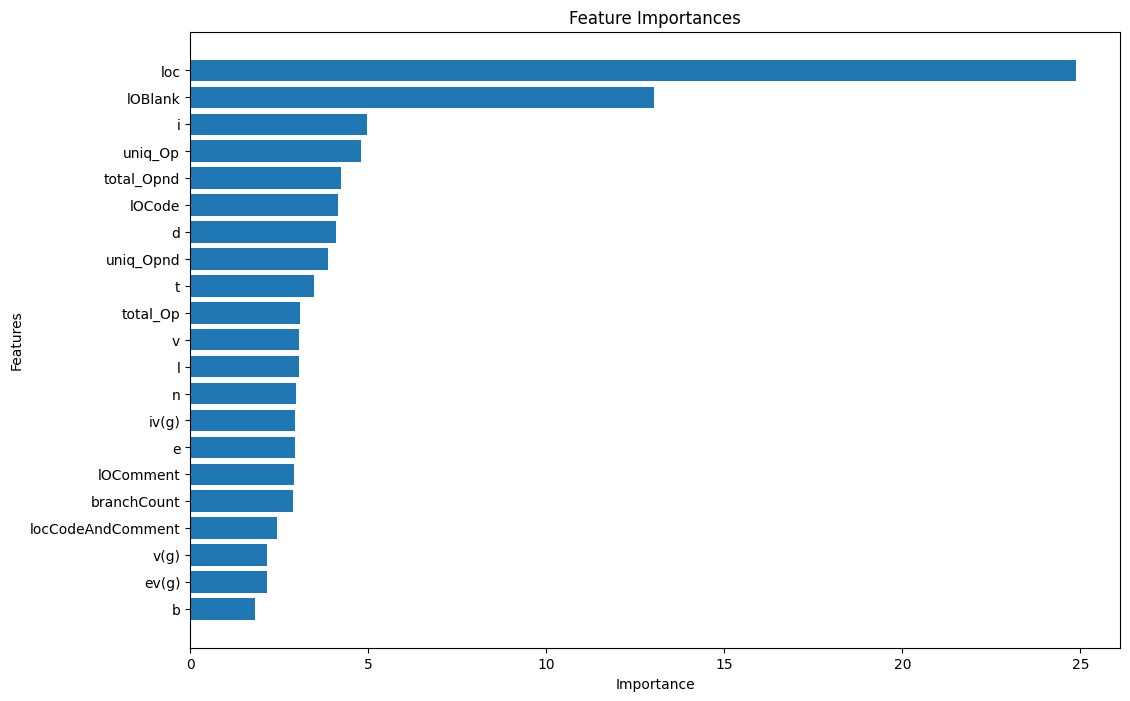

In [40]:
# Feature importances visualization
feature_importances = model_improved.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  
plt.show()